## Find marker genes and plot GO terms for updated developmental annotation in Shahan, Hsu et al 2022 WT Arabidopsis root atlas

In [1]:
library(tidyverse)
library(Seurat)
library(RColorBrewer)
library(future)
library(patchwork)
library(cowplot)
library(ComplexHeatmap)
library(circlize)
library(GeneOverlap)
library(gprofiler2)
library(ggrepel)
#for 200gb ram 
options(future.globals.maxSize = 200000 * 1024^2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'spatstat.geom':
  method     from
  print.boxx cli 

Attaching SeuratObject


Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots


Loading required package: grid

ComplexHeatmap version 2.11.1
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic d

In [2]:
sessionInfo()

R version 4.0.0 (2020-04-24)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 16.04.6 LTS

Matrix products: default
BLAS/LAPACK: /home/tmnolan7/anaconda3/envs/r_4/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggrepel_0.8.2         gprofiler2_0.2.0      GeneOverlap_1.24.0   
 [4] circlize_0.4.14       ComplexHeatmap_2.11.1 cowplot_1.1.0        
 [7] patchwork_1.1.0       future_1.22.1         RColorBrewer_1.1-2   
[10] SeuratObject_4.0.2    Seurat_4.0.5          forcats_0.5.0        
[13]

In [3]:
# Load WT atlas with updated dev annotation
rc.integrated <- readRDS("../data/integrations/Root_Atlas_v2_seu3_20220106.rds")

In [4]:
options(repr.plot.width=8, repr.plot.height=6)
# Plot celltype annotation 
order <- c("Quiescent Center", "Ground Tissue","Columella", "Lateral Root Cap", "Atrichoblast", "Trichoblast", "Cortex", "Endodermis", "Phloem","Protophloem", "Xylem", "Procambium","Pericycle","Phloem Pole Pericycle", "Protoxylem", "Metaxylem", "Unknown")
palette <- c("#9400D3", "#DCD0FF","#5AB953", "#BFEF45", "#008080", "#21B6A8", "#82B6FF", "#0000FF","#E6194B", "#DD77EC", "#9A6324", "#FFE119", "#FF9900", "#FFD4E3", "#9A6324", "#DDAA6F", "#EEEEEE")
rc.integrated$celltype.anno.Li.crude <- factor(rc.integrated$celltype.anno.Li.crude, levels = order[sort(match(unique(rc.integrated$celltype.anno.Li.crude),order))])
color <- palette[sort(match(unique(rc.integrated$celltype.anno.Li.crude),order))]

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



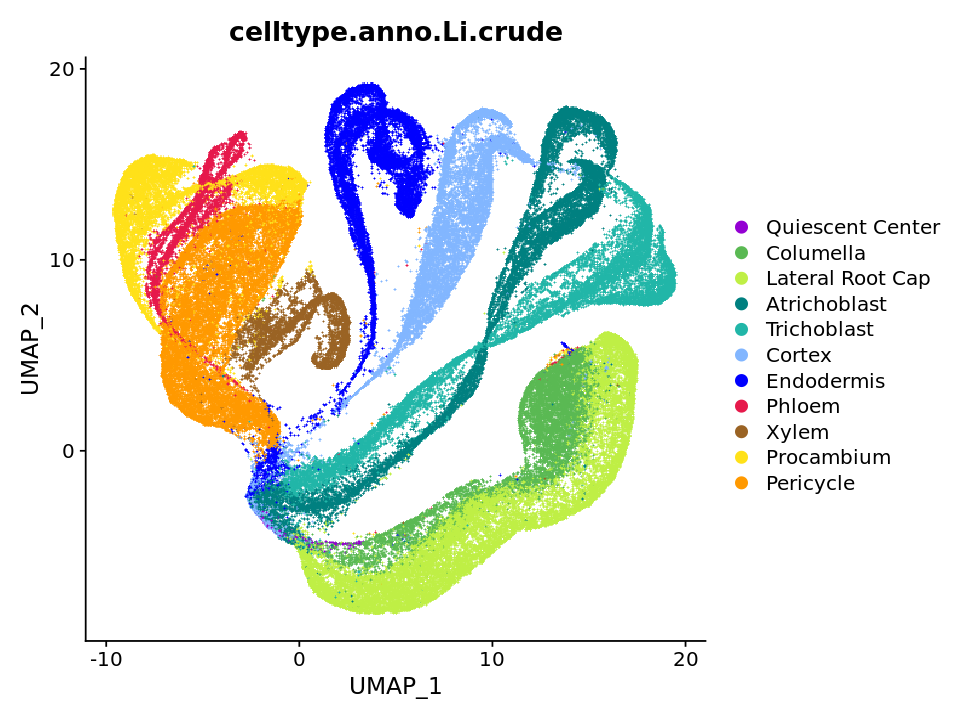

In [5]:
options(repr.plot.width=8, repr.plot.height=6)
(cell_plt <- DimPlot(rc.integrated, reduction = "umap", group.by = "celltype.anno.Li.crude", cols = color, pt.size=.5))

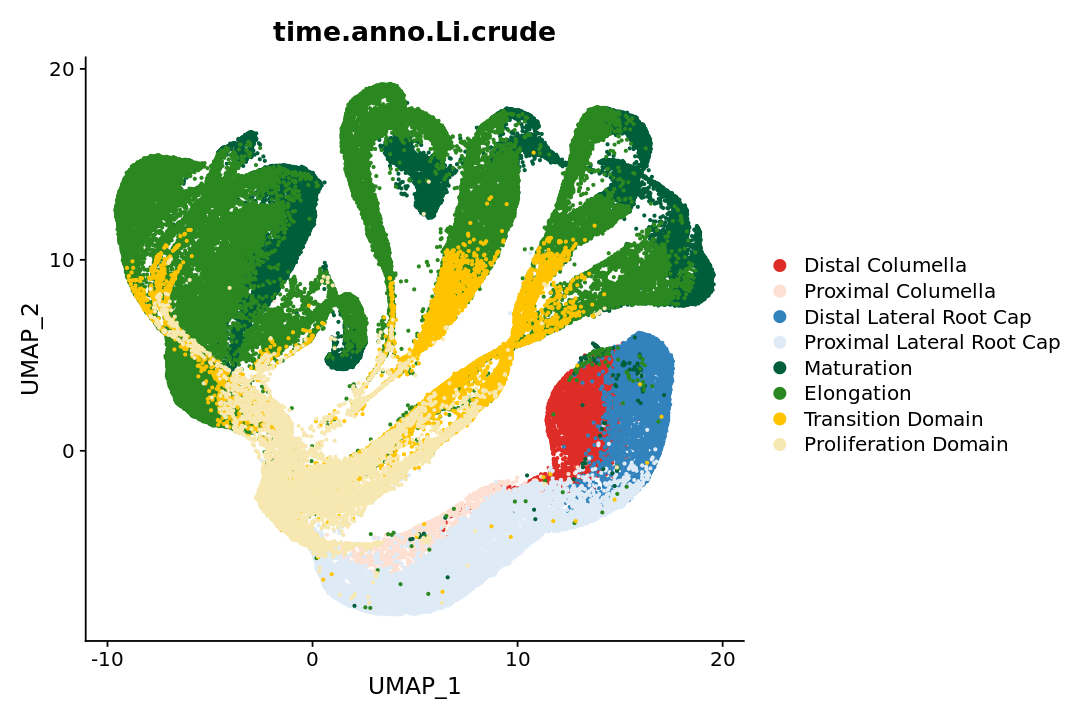

In [6]:
options(repr.plot.width=9, repr.plot.height=6)
# plot developmental stage annotation
(time_plt <- DimPlot(rc.integrated, 
        group.by = "time.anno.Li.crude", 
order = rev(c("Distal Columella","Proximal Columella","Distal Lateral Root Cap","Proximal Lateral Root Cap","Maturation","Elongation", "Transition Domain", "Proliferation Domain")),
        cols = rev(c('#F7E7B0','#FFC400','#2B871F','#005E3B', "#deebf7", "#3182bd", '#fee0d2','#de2d26')), 
                    pt.size=.5, 
                    raster=F))

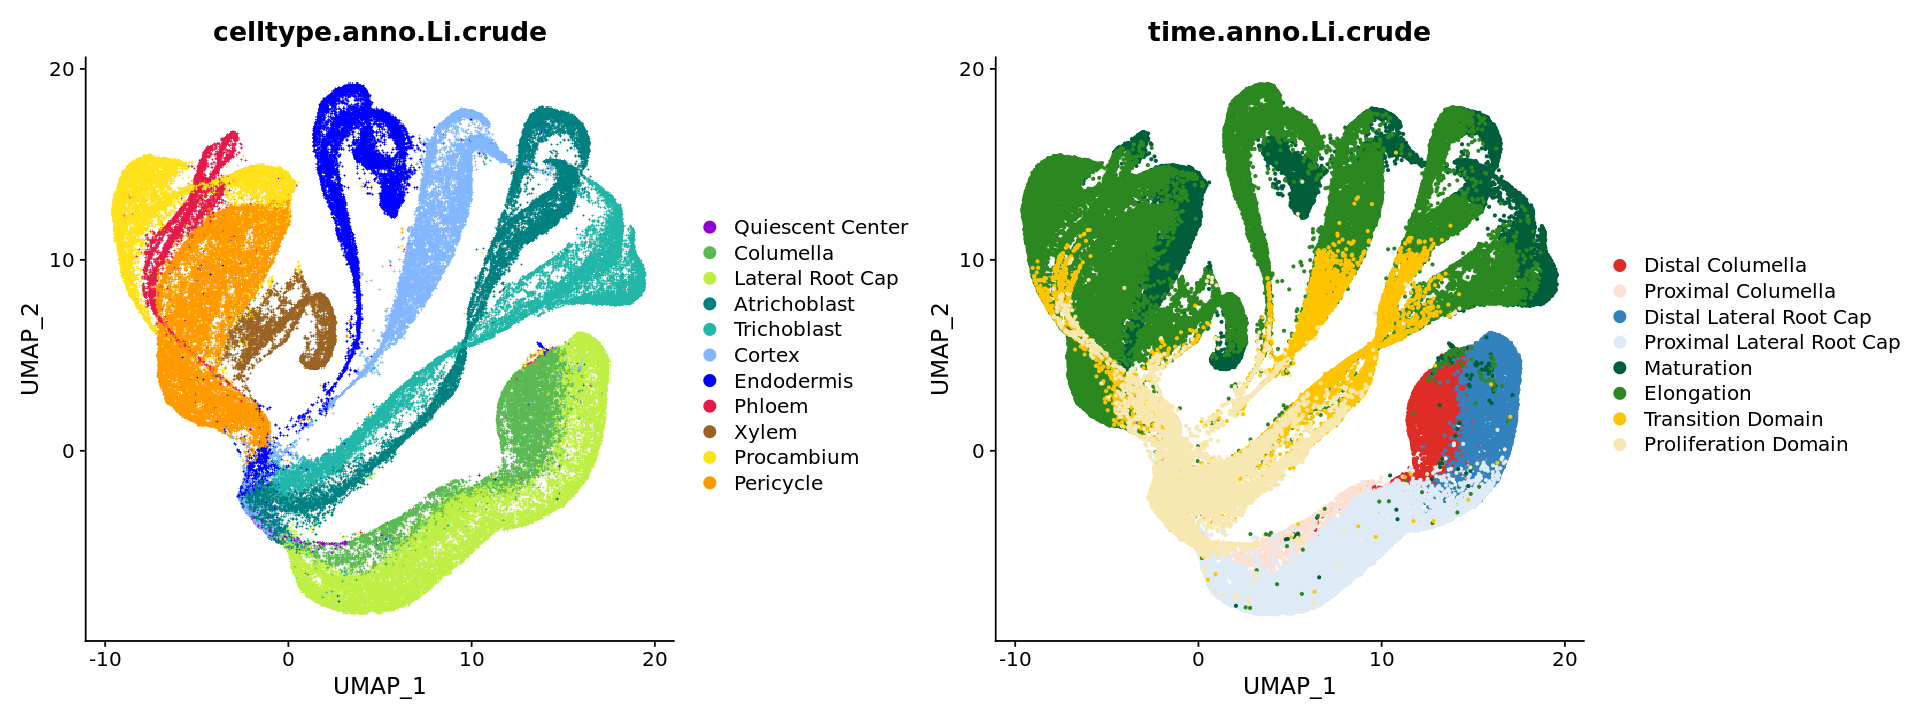

In [8]:
options(repr.plot.width=16, repr.plot.height=6)

cell_plt + time_plt 

ggsave("./output/atlas_tz_umaps.png", width=16, height=6)

In [9]:

Idents(rc.integrated) <- "time.anno.Li.crude" # dev stage anno as identity
DefaultAssay(rc.integrated) <- "integrated" # use integrated assay for corrected expression values

In [10]:
# Run Seurat FindMarkers with ROC method, downsampling to max of 10k cells per group
Clust_Markers <- FindAllMarkers(rc.integrated,
                                logfc.threshold=log(1.5),
                                min.diff.pct = 0.1,
                                max.cells.per.ident = 10000,
                                only.pos=T, 
                               test.use="roc")

Calculating cluster Transition Domain

Calculating cluster Elongation

Calculating cluster Distal Columella

Calculating cluster Proximal Lateral Root Cap

Calculating cluster Maturation

Calculating cluster Proliferation Domain

Calculating cluster Distal Lateral Root Cap

Calculating cluster Proximal Columella



In [11]:
# load gene names
feature_names <- read_tsv("./data/features.tsv.gz", col_names = c("gene", "Name", "Type")) %>%
  select(-Type) %>%
  distinct()


── Column specification ────────────────────────────────────────────────────────
cols(
  gene = col_character(),
  Name = col_character(),
  Type = col_character()
)




In [12]:
Clust_Markers <- left_join(Clust_Markers, feature_names)

Joining, by = "gene"



In [13]:
Clust_Markers %>% group_by(cluster) %>% top_n(5, myAUC)

myAUC,avg_diff,power,avg_log2FC,pct.1,pct.2,cluster,gene,Name
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>
0.890,2.030360,0.780,3.171961,0.923,0.279,Transition Domain,AT5G48580,FKBP15-2
0.884,2.841107,0.768,3.637958,0.905,0.311,Transition Domain,AT3G02230,RGP1
0.876,1.873240,0.752,3.387912,0.917,0.314,Transition Domain,AT5G14030,AT5G14030
0.869,2.998408,0.738,4.290938,0.831,0.224,Transition Domain,AT3G54770,ARP1
0.867,2.010946,0.734,3.708273,0.885,0.319,Transition Domain,AT1G32210,DAD1
0.867,3.347893,0.734,4.969700,0.847,0.254,Transition Domain,AT4G03190,GRH1
0.882,3.142215,0.764,4.505141,0.711,0.131,Elongation,AT5G56540,AGP14
0.875,3.901899,0.750,5.459335,0.677,0.118,Elongation,AT4G35100,PIP2-7
0.870,4.804169,0.740,6.744345,0.597,0.075,Elongation,AT5G53250,AGP22


In [14]:
Clust_Markers$cluster_gene <- paste(Clust_Markers$cluster, Clust_Markers$gene, sep="_")

In [15]:
# store all results 

All_clust_markers <- Clust_Markers

# subset based on AUC 0.6

Clust_Markers <- filter(Clust_Markers, myAUC>=0.6)

In [16]:
# how many times each gene is a marker
times_per_gene <- Clust_Markers %>%
ungroup() %>%
group_by(gene) %>%
tally()

Clust_Markers <- left_join(Clust_Markers, times_per_gene)

Joining, by = "gene"



# Plot overlap of marker genes for each developmental zone

png 
  2

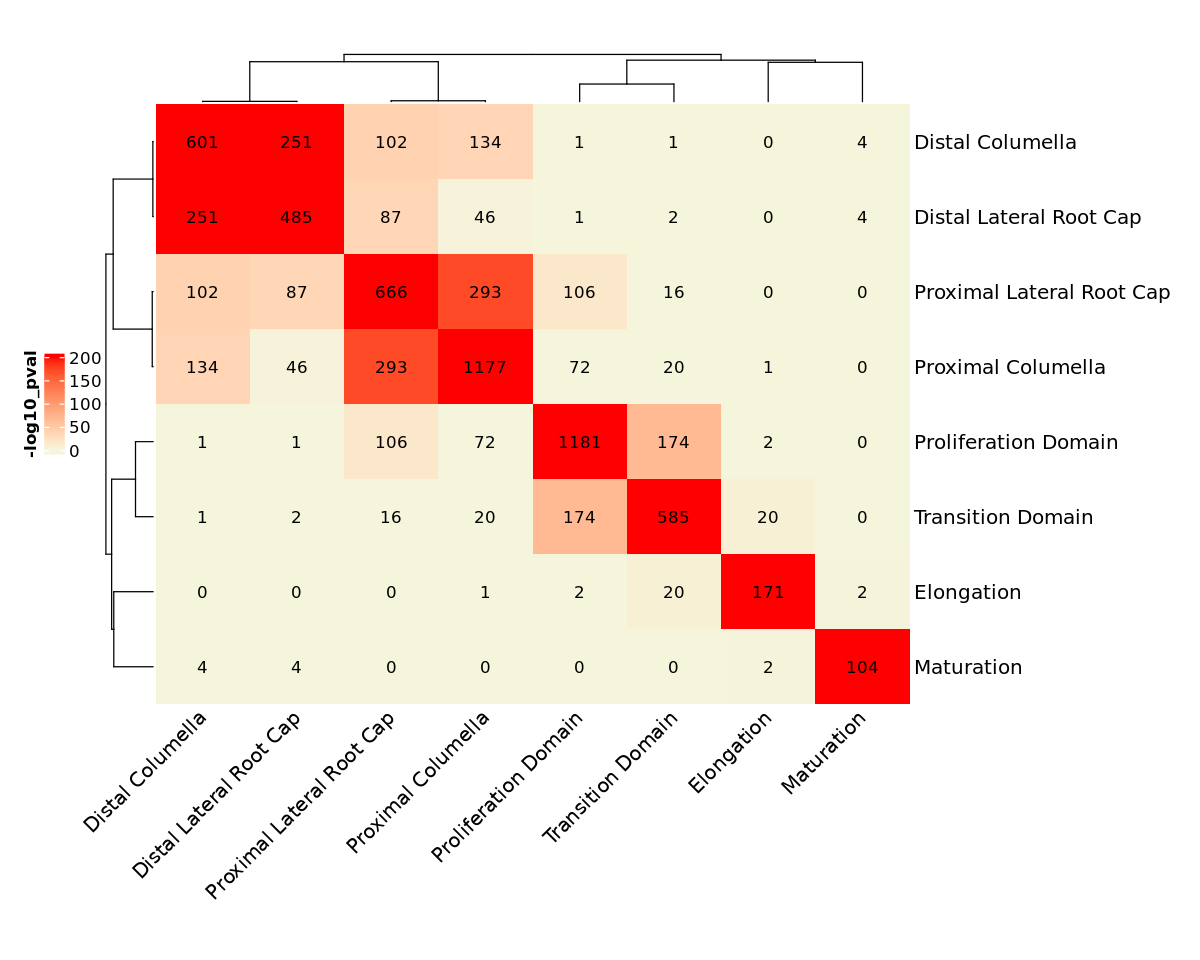

In [17]:
options(repr.plot.width = 10, repr.plot.height = 8)


markers_sel <- select(Clust_Markers, gene, cluster)

markers_list <- split(markers_sel, f=markers_sel$cluster)
 
#this makes list from long df of gene lists - TARGET is what we want to keep
markers_list  <- lapply(markers_list, function(x) x[names(x)=="gene"])
# convert each sublist into character and eliminate duplicates
markers_list  <- lapply(markers_list, function(x) as.character(unique(x$gene)))
 
## GeneOverlap 

# number of integrated features

genome_size <- 17513L

#compare all lists
gom.self <- newGOM(markers_list, markers_list, genome.size=genome_size)


int <- getNestedList(gom.self, "intersection")
int_matrix <- getMatrix(gom.self, "intersection")
p.val <- getMatrix(gom.self, "pval")
JC <- getMatrix(gom.self, "Jaccard")

# log of p.val for intersection
p.val_log <- -log10(p.val + 1e-200)


olap <- Heatmap(p.val_log, 
                name = "-log10_pval", 
                col = colorRamp2(c(0, 200), 
                                 c("beige", "red")), 
                column_title = " ", 
                heatmap_legend_param = list(title_position="leftcenter-rot", color_bar = "continuous"),
                cluster_rows = T,
                cluster_columns = T, 
                use_raster= FALSE, 
                show_column_names = TRUE, 
                show_row_names = TRUE, 
                show_row_dend = TRUE, 
                column_names_rot = 45,
                clustering_distance_rows = "pearson",
                clustering_distance_columns = "pearson", 
                show_column_dend = TRUE, cell_fun = function(j, i, x, y, width, height, fill) {grid.text(sprintf("%.0f", int_matrix[i, j]), x, y, gp = gpar(fontsize = 10))
}) 
                        
                        # padding - bottom, left, top, right
draw(olap, padding = unit(c(15, 5, 5, 10), "mm"), heatmap_legend_side = "left")
                        
                        
pdf(file = "./output/Dev_Zone_olap.pdf", width=10, height=8)
draw(olap, padding = unit(c(15, 5, 5, 10), "mm"), heatmap_legend_side = "left")
dev.off()

# GO Enrichment

In [18]:
cluster_GO <- gost(markers_list, organism = "athaliana", correction_method = "fdr", significant = F, multi_query = F)

cluster_GO_df <- cluster_GO[[1]]

cluster_GO_sig <- filter(cluster_GO_df, p_value<=0.01)

# top  terms for each cluster

cluster_GO_sig %>%
  filter(source=="GO:BP", intersection_size>=4) %>%
  group_by(query) %>%
  top_n(2, wt = -p_value) %>%
  arrange(desc(p_value)) -> top_GO

GO_n <- cluster_GO_sig %>%
  filter(source=="GO:BP", intersection_size>=4) %>%
  group_by(term_id) %>%
  tally() %>%
  arrange(desc(n))


GO_n <- dplyr::rename(GO_n, "n_clusters"=n)

cluster_GO_sig_n <- left_join(cluster_GO_sig, GO_n)

# get all terms for the top ones so that all clusters have values

top_GO_all <- filter(cluster_GO_df, term_id %in% top_GO$term_id)


#spread and plot


top_GO_sel <- select(top_GO_all, query, p_value, term_id, term_name)

spread_GO <- spread(top_GO_sel, key = query, p_value)

spread_GO[is.na(spread_GO)] <- 1

spread_GO_m <- as.matrix(-log10(spread_GO[3:ncol(spread_GO)]))
rownames(spread_GO_m) <- spread_GO$term_name



Joining, by = "term_id"



png 
  2

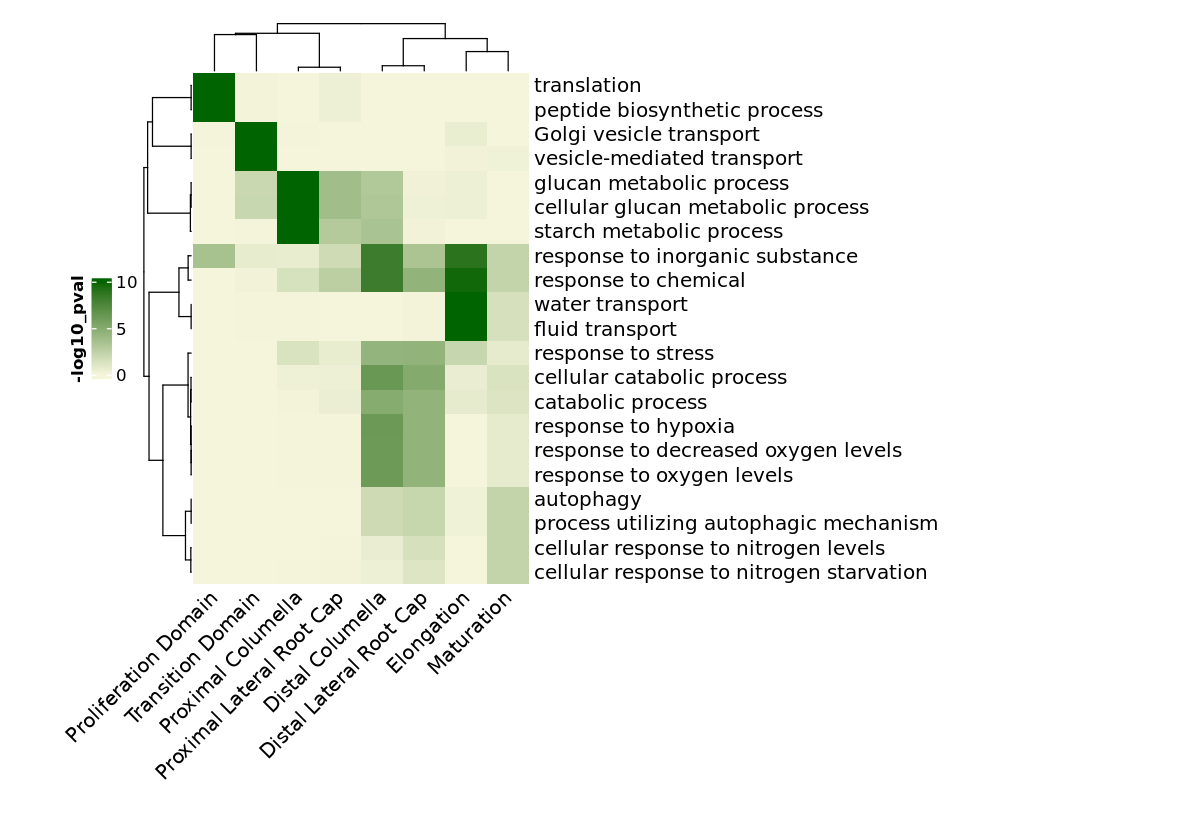

In [20]:
options(repr.plot.width = 10, repr.plot.height = 7)

GO_hm <- Heatmap(spread_GO_m, 
                 name = "-log10_pval", 
                 heatmap_legend_param = list(title_position="leftcenter-rot", color_bar = "continuous"), 
                 col = colorRamp2(c(0, 10), 
                                  c("beige", "darkgreen")), 
                 cluster_rows = T,
                 cluster_columns = T, 
                 use_raster= FALSE, 
                 show_column_names = TRUE, 
                 show_row_names = TRUE, 
                 show_row_dend = TRUE, 
                 show_column_dend = TRUE, 
                 column_names_rot = 45,
                 clustering_distance_rows = "pearson",
                 clustering_distance_columns = "pearson", 
                 row_names_gp = gpar(fontsize = 12)) 


# padding - bottom, left, top, right
draw(GO_hm, padding = unit(c(15, 15, 5, 80), "mm"), heatmap_legend_side = "left")

pdf(file = "./output/Dev_Zone_GO.pdf", width=10, height=7)
draw(GO_hm, padding = unit(c(15, 15, 5, 80), "mm"), heatmap_legend_side = "left")
dev.off()

In [21]:
# We rank the markers using the same method described in Shahan, Hsu et al., 2022

Clust_Markers <- mutate(Clust_Markers, pct.diff=pct.1-pct.2)
Clust_Markers <- arrange(Clust_Markers, desc(pct.diff)) %>%
group_by(cluster) %>%
mutate(pct.diff_rank=dplyr::row_number()) %>%
arrange(desc(avg_diff)) %>%
mutate(avg_diff_rank=dplyr::row_number()) %>%
arrange(desc(myAUC)) %>%
mutate(myAUC_rank=dplyr::row_number()) %>%
mutate(combined_rank_raw=(pct.diff_rank + avg_diff_rank + myAUC_rank)/3) %>%
arrange(combined_rank_raw) %>%
mutate(combined_rank=dplyr::row_number()) %>%
select(-combined_rank_raw) %>%
arrange(combined_rank)
Clust_Markers

myAUC,avg_diff,power,avg_log2FC,pct.1,pct.2,cluster,gene,Name,cluster_gene,n,pct.diff,pct.diff_rank,avg_diff_rank,myAUC_rank,combined_rank
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>,<int>,<dbl>,<int>,<int>,<int>,<int>
0.978,4.441985,0.956,6.418458,0.960,0.084,Distal Columella,AT1G05010,ACO4,Distal Columella_AT1G05010,2,0.876,1,2,2,1
0.803,4.185444,0.606,6.158215,0.615,0.064,Maturation,AT3G21710,VUP1,Maturation_AT3G21710,1,0.551,1,1,4,1
0.970,3.796814,0.940,5.578204,0.937,0.073,Proximal Lateral Root Cap,AT1G54010,GLL23,Proximal Lateral Root Cap_AT1G54010,2,0.864,1,8,1,1
0.870,4.804169,0.740,6.744345,0.597,0.075,Elongation,AT5G53250,AGP22,Elongation_AT5G53250,1,0.522,5,2,3,1
0.869,2.998408,0.738,4.290938,0.831,0.224,Transition Domain,AT3G54770,ARP1,Transition Domain_AT3G54770,2,0.607,2,7,4,1
0.975,4.195588,0.950,5.998051,0.964,0.079,Proximal Columella,AT2G04025,RGF3,Proximal Columella_AT2G04025,1,0.885,1,15,1,1
0.964,5.357063,0.928,7.568944,0.972,0.215,Proliferation Domain,AT3G55280,RPL23AB,Proliferation Domain_AT3G55280,1,0.757,12,3,11,1
0.954,3.201826,0.908,4.611937,0.964,0.152,Distal Lateral Root Cap,AT1G30720,AT1G30720,Distal Lateral Root Cap_AT1G30720,2,0.812,3,32,3,1
0.806,3.835358,0.612,5.328663,0.596,0.084,Maturation,AT3G14280,AT3G14280,Maturation_AT3G14280,1,0.512,3,3,3,2


In [22]:
write.csv(Clust_Markers, "./output/Data_S2_Marker_genes_updated_dev_annotation.csv", row.names=F)